In [1]:
import sys,os
import csv
import pickle
import scipy
import numpy as np
import json
from IPython.display import clear_output
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def pearsons_whole_stats(x,y):
    """
    This function computes the pearson's correlation coefficient between two variables x and y.
    It also computes the relative confidence interval from 5th to 95th percentile, and returns
    the p-value of the null hypothesis that the correlation coefficient is 0.
    """

    r, p = scipy.stats.pearsonr(x,y)

    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    alpha = 0.05
    z = scipy.stats.norm.ppf(1-alpha/2)

    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))

    output = {"coeff":r, "p_value":p, "lo":lo, "hi":hi}
    
    return output


def map_to_orientation(lrgen):
    """
    This function classifies parties' political orientations using the "lrgen" field of CHES 2017
    """
    
    if lrgen<4: return "Left-wing"
    elif lrgen<6: return "Other"
    else: return "Right-wing"
    
    
populist_parties = {
    "IT":['Northern League', 'PaP', 'M5S', 'Brothers of Italy'],

    "FR":['National Front','Indomitable France'],
    "AT":['Austrian Freedom Party','Alliance for the Future of Austria','Team Stronach for Austria'],

    "NL":['Party of Freedom','List Pim Fortuyn','Socialist Party','Forum for Democracy'],
    "ES":['We can','In Common We Can',"Vox"],
    "DE":['The Left','Alternative for Germany']
    
}

parties_to_exclude = {
    "IT":['Forward Italy', 'PdL', 'Italy of Values', 'Casapound', 'Houses of Freedom'],

    "FR":['The Greens','French Communist Party', "Nouveau Parti Anticapitaliste", "Resistons",'Debout la France'],
    "AT":['Peter Pilz List'],

    "NL":['DENK','Party for the Animals','Reformed Political Party','50Plus','Green Left'],
    "ES":["Citizens"],
    "DE":['Pirates']
}

# Normal Scores

In [3]:
nations = [ "IT","FR", "ES", "DE", "NL", "AT"]

df_global_scores = None

for nation in nations:
    
    if df_global_scores is None:
        df_global_scores = pd.read_csv("./scores/global_scores_{}.csv".format(nation))
        df_global_scores["nation"] = nation
        df_global_scores["isExcluded"] = [party in parties_to_exclude[nation] for party in df_global_scores.party.values]
    else:
        df_global_scores_aux = pd.read_csv("./scores/global_scores_{}.csv".format(nation))
        df_global_scores_aux["nation"] = nation
        df_global_scores_aux["isExcluded"] = [party in parties_to_exclude[nation] for party in df_global_scores_aux.party.values]
        df_global_scores = pd.concat([df_global_scores,df_global_scores_aux], axis=0)
        
df_global_scores.index = range(len(df_global_scores))
df_global_scores = df_global_scores.iloc[df_global_scores.score.sort_values(ascending=False).index]
df_global_scores.index = range(len(df_global_scores))
df_global_scores.head(n=10)

,party,score,orientation,counts,nation,isExcluded
0,In Common We Can,0.912437,Left-wing,1576,ES,False
1,Casapound,0.868421,Right-wing,38,IT,True
2,M5S,0.833948,Other,271,IT,False
3,The Left,0.678170,Left-wing,1246,DE,False
4,Indomitable France,0.659443,Left-wing,323,FR,False
5,Austrian Freedom Party,0.641851,Right-wing,497,AT,False
6,Democracy and Freedom,0.621762,Right-wing,579,ES,False
7,National Front,0.609170,Right-wing,458,FR,False
8,Socialist Party,0.587161,Left-wing,1698,NL,False
9,PaP,0.555556,Left-wing,9,IT,False


In [4]:
nations = [ "IT","FR", "ES", "AT", "DE", "NL"]

df_scores_in_time = None

for nation in nations:
    
    if df_scores_in_time is None:
        df_scores_in_time = pd.read_csv("./scores/scores_in_time_{}.csv".format(nation))
        df_scores_in_time["nation"] = nation
        df_scores_in_time["isExcluded"] = [party in parties_to_exclude[nation] for party in df_scores_in_time.party.values]

    else:
        df_scores_in_time_aux = pd.read_csv("./scores/scores_in_time_{}.csv".format(nation))
        df_scores_in_time_aux["nation"] = nation
        df_scores_in_time_aux["isExcluded"] = [party in parties_to_exclude[nation] for party in df_scores_in_time_aux.party.values]

        df_scores_in_time = pd.concat([df_scores_in_time,df_scores_in_time_aux], axis=0)
df_scores_in_time = df_scores_in_time.rename(columns={"nation":"country_name"})
df_scores_in_time["party_country_name"] = [party+"_"+country_name for party, country_name in df_scores_in_time[["party","country_name"]].values]
       
df_scores_in_time.head(n=10)

,party,year,score,orientation,counts,country_name,isExcluded,party_country_name
0,Democratic Center,2013.0,0.101562,Other,128,IT,False,Democratic Center_IT
1,Communist Refoundation Party,2001.0,0.029641,Left-wing,641,IT,False,Communist Refoundation Party_IT
2,SVP,2013.0,0.000000,Left-wing,252,IT,False,SVP_IT
3,European Democracy,2001.0,0.094340,Other,53,IT,False,European Democracy_IT
4,Civic Choice,2013.0,0.111111,Left-wing,144,IT,False,Civic Choice_IT
5,The Union,2006.0,0.182927,Left-wing,82,IT,False,The Union_IT
6,UDC,2013.0,0.153226,Other,124,IT,False,UDC_IT
7,Northern League,2008.0,0.318841,Right-wing,69,IT,False,Northern League_IT
8,Civil Revolution,2013.0,0.081481,Left-wing,135,IT,False,Civil Revolution_IT
9,PD,2018.0,0.372881,Left-wing,118,IT,False,PD_IT


# Reshuffled Scores

In [5]:
nations = [ "IT","FR", "ES", "DE", "NL", "AT"]

df_global_scores_resh = None

for nation in nations:
    
    if df_global_scores is None:
        df_global_scores_resh = pd.read_csv("./scores_resh/global_scores_{}.csv".format(nation))
        df_global_scores_resh["nation"] = nation
        df_global_scores_resh["isExcluded"] = [party in parties_to_exclude[nation] for party in df_global_scores_resh.party.values]

    else:
        df_global_scores_resh_aux = pd.read_csv("./scores_resh/global_scores_{}.csv".format(nation))
        df_global_scores_resh_aux["nation"] = nation
        df_global_scores_resh_aux["isExcluded"] = [party in parties_to_exclude[nation] for party in df_global_scores_resh_aux.party.values]

        df_global_scores_resh = pd.concat([df_global_scores_resh,df_global_scores_resh_aux], axis=0)
        
df_global_scores_resh.index = range(len(df_global_scores_resh))
df_global_scores_resh = df_global_scores_resh.iloc[df_global_scores_resh.score.sort_values(ascending=False).index]
df_global_scores_resh.index = range(len(df_global_scores_resh))
df_global_scores_resh.head(n=10)

,party,score,orientation,counts,random_state,nation,isExcluded
0,LeU,1.0,Left-wing,3,47,IT,False
1,Brothers of Italy,1.0,Right-wing,236,83,IT,False
2,Brothers of Italy,1.0,Right-wing,7,90,IT,False
3,European Democracy,1.0,Other,5,31,IT,False
4,Civic Choice,1.0,Left-wing,2,3,IT,False
5,The Olive Tree,1.0,Left-wing,7,58,IT,False
6,Communist Refoundation Party,1.0,Left-wing,2,16,IT,False
7,Civil Revolution,1.0,Left-wing,7,9,IT,False
8,Brothers of Italy,1.0,Right-wing,269,8,IT,False
9,PaP,1.0,Left-wing,5,35,IT,False


In [6]:
nations = [ "IT","FR", "ES", "AT", "DE", "NL"]

df_scores_in_time_resh = None

for nation in nations:
    
    if df_scores_in_time_resh is None:
        df_scores_in_time_resh = pd.read_csv("./scores_resh/scores_in_time_{}.csv".format(nation))
        df_scores_in_time_resh["nation"] = nation
        df_scores_in_time_resh["isExcluded"] = [party in parties_to_exclude[nation] for party in df_scores_in_time_resh.party.values]

    else:
        df_scores_in_time_resh_aux = pd.read_csv("./scores_resh/scores_in_time_{}.csv".format(nation))
        df_scores_in_time_resh_aux["nation"] = nation
        df_scores_in_time_resh_aux["isExcluded"] = [party in parties_to_exclude[nation] for party in df_scores_in_time_resh_aux.party.values]

        df_scores_in_time_resh = pd.concat([df_scores_in_time_resh,df_scores_in_time_resh_aux], axis=0)
     
df_scores_in_time_resh = df_scores_in_time_resh.rename(columns={"nation":"country_name"})
df_scores_in_time_resh["party_country_name"] = [party+"_"+country_name for party, country_name in df_scores_in_time_resh[["party","country_name"]].values]

df_scores_in_time_resh.head(n=10)

,party,year,score,orientation,counts,random_state,country_name,isExcluded,party_country_name
0,UDC,2018.0,0.591667,Other,120,0,IT,False,UDC_IT
1,LeU,2018.0,0.212245,Left-wing,245,0,IT,False,LeU_IT
2,PD,2008.0,0.061947,Left-wing,113,0,IT,False,PD_IT
3,The Union,2006.0,0.118557,Left-wing,194,0,IT,False,The Union_IT
4,Civic Choice,2013.0,0.539326,Left-wing,89,0,IT,False,Civic Choice_IT
5,Labour and Freedom List,2013.0,0.773333,Right-wing,75,0,IT,False,Labour and Freedom List_IT
6,UDC,2013.0,0.066667,Other,630,0,IT,False,UDC_IT
7,Civil Revolution,2013.0,0.262069,Left-wing,145,0,IT,False,Civil Revolution_IT
8,PD,2018.0,0.018182,Left-wing,220,0,IT,False,PD_IT
9,Communist Refoundation Party,2001.0,0.239130,Left-wing,138,0,IT,False,Communist Refoundation Party_IT


# Overlappings

In [7]:
overlap_data = []

for nation in nations:
    for random_state in sorted(df_global_scores_resh.random_state.unique()):
        random_mapping = pickle.load( open("./datasets_resh/{0}_remapping_{1}.pkl".format(nation, random_state), "rb"))

        overlaps = 0
        for pyo, pyo_resh in random_mapping.items():
            p = pyo[0]
            p_resh = pyo_resh[0]
            if p in populist_parties[nation] and p_resh in populist_parties[nation]: overlaps+=1

        overlaps = overlaps/len(random_mapping)
        
        overlap_data.append({"nation":nation, "random_state":random_state, "overlaps":overlaps})
        
df_overlap_resh = pd.DataFrame(overlap_data)

# Correlation with latent variable

In [8]:
print("reading POPPA dataset...")
df_poppa = pd.read_csv("./POPPA_data/poppa_and_latent_variable.csv")
df_poppa = df_poppa[["country_id","party",'peoplecentrism',\
         'manichean','indivisble','generalwill','antielitism',"latent", "lroverall"]]

#############
country_mapping = {
    "GE":"DE",
    "IT":"IT",
    "FR":"FR",
    "NL":"NL",
    "SP":"ES",
    "AU":"AT",

}


party_mapping = {
    
    "DE":{
        "CDU":"Christian Democratic Union-Christian Social Union",
        "SPD":"Social Democratic Party of Germany",
        "B90Grune":"Alliance‘90-Greens",
        "Linke":"The Left",
        "AfD":"Alternative for Germany",
    },
    
    "IT":{
        "LN":"Northern League",
        "UDC":"UDC",
        "PD":"PD",
        "CD":"Democratic Center",
        "FdlCN":"Brothers of Italy",
        "M5S":"M5S",
    },
    
    "FR":{
        "PCF":"French Communist Party",
        "PS":"Socialist Party",
        "EELV":"The Greens",
        "LR":"Union for a Popular Movement",
        "FN":"National Front",
        "MoDem":"Democratic Mouvement",
        "LaREM":"Republic Onwards!",
        "LFI":"Indomitable France",
        "DLF":"Debout la France",
        "NPA":"Nouveau Parti Anticapitaliste"
    },
    
    "ES":{
        "PSOE":"Spanish Socialist Workers’ Party",
        "PP":"People's Party",
        "Podemos":"We can",
    },
    
    "NL":{
        "CDA":"Christian Democratic Appeal",
        "PvdA":"Labour Party",
        "VVD":"People’s Party for Freedom and Democracy",
        "D66":"Democrats‘66",
        "GL":"Green Left",
        "SGP":"Reformed Political Party",
        "SP":"Socialist Party",
        "CU":"Christian Union",
        "PVV":"Party of Freedom",
        "PvdD":"Party for the Animals",
        "50Plus":"50Plus",
        "DENK":"DENK",
        "FvD":"Forum for Democracy",
    },
    
    
    "AT":{
        'PILZ':"Peter Pilz List",
        "FPO":"Austrian Freedom Party",
        "Gruene": "The Greens",
        "NEOS": "The New Austria",
        "OVP": "Austrian People’s Party",
        "SPO":"Austrian Social Democratic Party"
    }
    
}

##############
print("changing country identifiers...")
df_poppa = df_poppa[df_poppa.country_id.isin(country_mapping.keys())].copy()
df_poppa["country_id"] = [country_mapping[country] for country in df_poppa.country_id]
df_poppa = df_poppa.rename(columns={"country_id":"nation"})
##############
print("mapping POPPA party names to our notation...")

df_poppa["old_party"] = [party for party in df_poppa.party]
for nation in party_mapping:
    new_party = []
    for party in df_poppa.loc[df_poppa.nation==nation, "party"].values:
        try: new_party.append(party_mapping[nation][party])
        except KeyError: new_party.append( "missing")
    df_poppa.loc[df_poppa.nation==nation, "party"] =new_party

df_poppa = df_poppa[df_poppa.party != "missing"]
##############

print("merging dataframes..")
df_poppa = pd.merge(df_poppa,df_global_scores, on=["nation", "party"], how="left",suffixes=("_poppa","_score") )
df_poppa["orientation_poppa"] = [map_to_orientation(lroverall) for lroverall in df_poppa.lroverall.values]

# df_poppa = df_poppa[df_poppa.isExcluded]
##############

reading POPPA dataset...
changing country identifiers...
mapping POPPA party names to our notation...
merging dataframes..


__standard corrs__

In [9]:
res = pearsons_whole_stats(df_poppa.score.values, df_poppa.latent.values)
res = {k:round(res[k],3) for k in res}
print("\t Corr. coeff = {0} with CI [{1},{2}], p-value = {3}".format(res["coeff"], res["lo"], res["hi"], res["p_value"]))


	 Corr. coeff = 0.815 with CI [0.677,0.897], p-value = 0.0


In [10]:
r_resh_list = []
p_values_list = []
for random_state in sorted(df_global_scores_resh.random_state.unique()):
    df_global_scores_resh_aux = df_global_scores_resh[df_global_scores_resh.random_state==random_state]
    df_poppa_with_resh = pd.merge(df_poppa,df_global_scores_resh_aux[["nation","party","score"]], on=["nation", "party"], how="left",suffixes=("","_resh{}".format(random_state)) )

    res_resh = pearsons_whole_stats(df_poppa_with_resh["score_resh{}".format(random_state)].values, df_poppa_with_resh.latent.values)
    r_resh_list.append(res_resh["coeff"])
    p_values_list.append(res_resh["p_value"])
    


Text(0.815, 2.0, 'est. value')

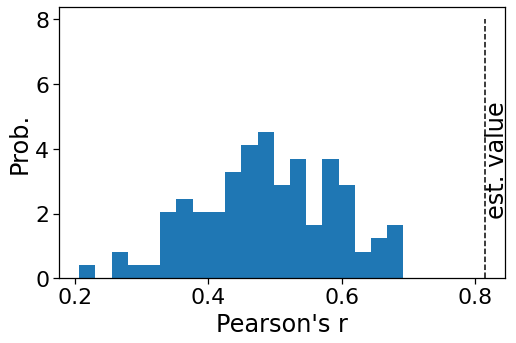

In [11]:
sns.set_context("notebook", font_scale=2)
fig = plt.figure(figsize=(8,5))

ax = fig.add_subplot(111)
ax.hist(r_resh_list,bins=20, density=True)
ax.set_xlabel("Pearson's r")
ax.set_ylabel("Prob.")

v_up = 8
ax.vlines(res["coeff"],0,v_up, color="black", linestyle="dashed")
ax.text(res["coeff"], v_up/4, "est. value", rotation=90)

# Corr. with Manual Coding

In [15]:
df_IT_manual = pd.read_csv("./scores/global_scores_IT_manual.csv")
df_IT = df_global_scores[df_global_scores.nation=="IT"]
df_IT_resh = df_global_scores_resh[df_global_scores_resh.nation=="IT"]

#########

df_merged = pd.merge(df_IT,df_IT_manual, on = ["party"], suffixes=("", "_manual"))

###########


	 Corr. coeff = 0.791 with CI [0.535,0.914], p-value = 0.0


Text(0.791, 0.75, 'est. value')

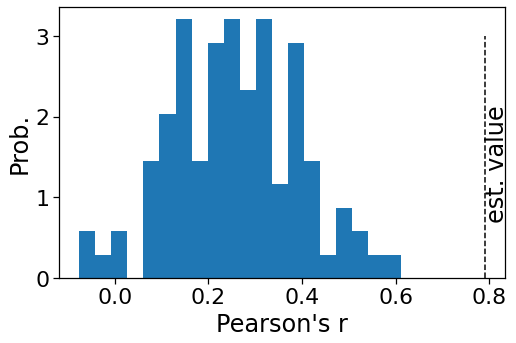

In [16]:
res = pearsons_whole_stats(df_merged.score_manual.values, df_merged.score.values)
res = {k:round(res[k],3) for k in res}
print("\t Corr. coeff = {0} with CI [{1},{2}], p-value = {3}".format(res["coeff"], res["lo"], res["hi"], res["p_value"]))


r_resh_list = []
p_values_list = []
for random_state in sorted(df_IT_resh.random_state.unique()):
    df_IT_resh_aux = df_IT_resh[df_IT_resh.random_state==random_state]
    df_merged_with_resh = pd.merge(df_merged,df_IT_resh_aux[["nation","party","score"]], on=["nation", "party"], how="left",suffixes=("","_resh{}".format(random_state)) )
    df_merged_with_resh = df_merged_with_resh.dropna()
    res_resh = pearsons_whole_stats(df_merged_with_resh["score_resh{}".format(random_state)].values, df_merged_with_resh.score_manual.values)
    r_resh_list.append(res_resh["coeff"])
    p_values_list.append(res_resh["p_value"])

sns.set_context("notebook", font_scale=2)
fig = plt.figure(figsize=(8,5))

ax = fig.add_subplot(111)
ax.hist(r_resh_list,bins=20, density=True)
ax.set_xlabel("Pearson's r")
ax.set_ylabel("Prob.")

v_up = 3
ax.vlines(res["coeff"],0,v_up, color="black", linestyle="dashed")
ax.text(res["coeff"], v_up/4, "est. value", rotation=90)